# 3+ Clustering with Max-cut
This notebook is an example of unsupervised learning on a quantum computer. The data used are from the iris data set.

This is an extension of the notebook 'Max-cut' where solving the max-cut problem with QAOA gave a quantum speed up to unsupervised learning. The method is an effective binary classifier. In this notebook, we focus on techniques that allow this binary classified to cluster 3+ groups.

## 3+ Clusters *(currently in progress)*
How can a binary classifier, like QAOA solving the max-cut problem, be used to cluster data into more than 2 groups?

## Divisive Hierarchical Quantum Clustering
One solution is to apply a divisive ("top-down") [hierarchial clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering) method: (0) solve the max-cut problem on the entire dataset, (1) assume the resulting two child clusters are whole 'natural' clusters or groups of whole 'natural' clusters, repeat (0)-(1) with the child clusters. Where a 'natural' cluster would be the species in this case. In the real world, the 'natural' clustering is exactly what we're trying to find! Though, in the real world, there may not be a 'natural' clustering we are interseted in; rather, we want to see how the data is splits all the way down to the individual data point. In either case this approach is useful and has a quantum speed up due to QAOA solving the max-cut problem!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load IBM quantum computing options
from qiskit import IBMQ
IBMQ.load_account()  # Load account from disk

# Quantum Computing packages
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QAOA
from qiskit.aqua.translators.ising import max_cut
from qiskit.aqua.components.optimizers import COBYLA

In [2]:
# Import Iris dataset
df = pd.read_csv('Data/iris.csv')
df.drop(["Id"],axis=1,inplace=True)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
# Compute pairwise L2-norms
import itertools

def calc_w(data_array):
    n_instances = data_array.shape[0]
    w = np.zeros((n_instances, n_instances))
    for i, j in itertools.product(*[range(n_instances)]*2):
        w[i, j] = np.linalg.norm(data_array[i]-data_array[j])
    return w

In [5]:
# Remove Iris labels and Sepal dimensions
data_full = df.loc[:,['PetalLengthCm','PetalWidthCm','SepalLengthCm','SepalWidthCm',]]

# Reduce number of data points, will be removed later
# Dataframe with species labels
df_sub = df[:-10:9]
# Dataframe without species lables
data_sub = data_full[:-10:9]
data_sub

,PetalLengthCm,PetalWidthCm,SepalLengthCm,SepalWidthCm
0,1.4,0.2,5.1,3.5
9,1.5,0.1,4.9,3.1
18,1.7,0.3,5.7,3.8
27,1.5,0.2,5.2,3.5
36,1.3,0.2,5.5,3.5
45,1.4,0.3,4.8,3.0
54,4.6,1.5,6.5,2.8
63,4.7,1.4,6.1,2.9
72,4.9,1.5,6.3,2.5
81,3.7,1.0,5.5,2.4


In [6]:
data_sub

,PetalLengthCm,PetalWidthCm,SepalLengthCm,SepalWidthCm
0,1.4,0.2,5.1,3.5
9,1.5,0.1,4.9,3.1
18,1.7,0.3,5.7,3.8
27,1.5,0.2,5.2,3.5
36,1.3,0.2,5.5,3.5
45,1.4,0.3,4.8,3.0
54,4.6,1.5,6.5,2.8
63,4.7,1.4,6.1,2.9
72,4.9,1.5,6.3,2.5
81,3.7,1.0,5.5,2.4


In [7]:
# Minimum iterations to turn most datapoints into their own clusters
r = int(np.log2(len(data_sub)))

# Copy data for manipulation
data = data_sub.copy()

# QAOA hyperparameters
p = 1  # Number of adiabatic steps must be >= 1
optimizer = COBYLA()  # Arbitrary selection
provider = IBMQ.get_provider(group='open')  # Load provider to access backends
backend_ibm = provider.get_backend('ibmq_qasm_simulator')  # Simulate using IBM's cloud service
backend_local = BasicAer.get_backend('statevector_simulator')  # Simulate using local machine

for i in range(0,r):
    # Initialize 'labels' column for future QAOA output
    data['cluster_'+str(i)] = np.nan
    data['cut_'+str(i)] = np.nan
    
    # Select subsets of data based on clustering from previous execution
    dfs = []
    if i != 0:
        cluster_range = data['cluster_'+str(i-1)].unique()
        for j in cluster_range:
            print('cluster_'+str(i-1),j)
            df_cluster = data[data['cluster_'+str(i-1)] == j][data.columns[:4]]
            # if df_cluster length is 1 then it can't be further cut, so only consider lengths > 1
            if len(df_cluster.index) > 1:
                dfs.append(df_cluster)
    else:
        dfs.append(data[data.columns[:4]])

    for j, df_part in enumerate(dfs):
        df_part_array = df_part.values
        w = calc_w(df_part_array)  # Calculate pairwise distances between points
        #print('w size:',w.shape,w)
        #w = calc_w_exp_decay(df_part_array)  # Calculate pairwise distances between points
        # Execute algorithm
        qubit_ops, offset = max_cut.get_max_cut_qubitops(w)
        qaoa = QAOA(qubit_ops, optimizer, p)
        if w.shape[0] > 12:
            backend = backend_ibm
        else:
            backend = backend_local
        quantum_instance = QuantumInstance(backend, shots=1)
        result = qaoa.run(quantum_instance)

        # Extract results
        x = max_cut.sample_most_likely(result['eigvecs'][0])

        # Put labels back into full data array. Labels must be unqiue each iteration
        df_part['cluster_'+str(i)] = max_cut.get_graph_solution(x) + 2*j
        df_part['cut_'+str(i)] = max_cut.max_cut_value(x, w)
        
        data.update(df_part)

    print('Iteration',i+1,'of',r,'completed')

The skip Qobj validation does not work for IBMQ provider. Disable it.
/Users/Razander/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Iteration 1 of 4 completed
cluster_0 0.0
cluster_0 1.0
Iteration 2 of 4 completed
cluster_1 1.0
cluster_1 3.0
cluster_1 0.0
cluster_1 2.0
Iteration 3 of 4 completed
cluster_2 0.0
cluster_2 3.0
cluster_2 1.0
cluster_2 5.0
cluster_2 2.0
cluster_2 4.0
cluster_2 nan
Iteration 4 of 4 completed


In [8]:
# Include results in df_sub dataframe for analysis
for i in range(0,r):
    df_sub.loc[:,'cluster_'+str(i)] = data.loc[:,'cluster_'+str(i)]
    df_sub.loc[:,'cut_'+str(i)] = data.loc[:,'cut_'+str(i)]
df_sub

/Users/Razander/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Razander/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,cluster_0,cut_0,cluster_1,cut_1,cluster_2,cut_2,cluster_3,cut_3
0,5.1,3.5,1.4,0.2,Iris-setosa,0.0,158.04068,1.0,33.843560,0.0,3.903707,NaN,NaN
9,4.9,3.1,1.5,0.1,Iris-setosa,1.0,158.04068,3.0,34.683371,3.0,71.843788,0.0,2.840038
18,5.7,3.8,1.7,0.3,Iris-setosa,1.0,158.04068,3.0,34.683371,3.0,71.843788,1.0,2.840038
27,5.2,3.5,1.5,0.2,Iris-setosa,1.0,158.04068,3.0,34.683371,3.0,71.843788,0.0,2.840038
36,5.5,3.5,1.3,0.2,Iris-setosa,1.0,158.04068,3.0,34.683371,3.0,71.843788,1.0,2.840038
45,4.8,3.0,1.4,0.3,Iris-setosa,0.0,158.04068,1.0,33.843560,1.0,3.903707,2.0,3.234192
54,6.5,2.8,4.6,1.5,Iris-versicolor,0.0,158.04068,0.0,33.843560,5.0,5.358772,5.0,0.469042
63,6.1,2.9,4.7,1.4,Iris-versicolor,1.0,158.04068,3.0,34.683371,2.0,71.843788,7.0,9.264187
72,6.3,2.5,4.9,1.5,Iris-versicolor,1.0,158.04068,3.0,34.683371,2.0,71.843788,7.0,9.264187
81,5.5,2.4,3.7,1.0,Iris-versicolor,1.0,158.04068,3.0,34.683371,2.0,71.843788,6.0,9.264187


In [25]:
cluster_ids

[2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5]

In [22]:
cuts

[158.04068024173566,
 33.84356045819272,
 34.68337090303373,
 3.9037070106458014,
 71.8437883066644,
 5.358771696727168,
 nan,
 nan,
 2.8400383709133132,
 3.2341923257592464,
 0.4690415759823429,
 9.264186964667967]

The stop criteria is an elbow rule varient I dub the "High Road Rule". It's similar to the elbow rule where we want the number of clusters that most reduces the max-cut weight per additional cluster. However, on top of picking the number of clusters--where the elbow happens--we want to pick the largest max-cut weight at that elbow as well.

ValueError: x and y must be the same size

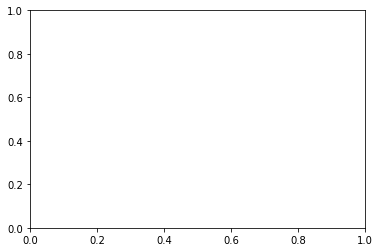

In [24]:
cuts = []
cluster_ids = []
for i in range(0,r):
    # Collect max-cut weights
    cuts += list(df_sub['cut_'+str(i)].unique())
    # Number how many clusters have been made for this cut
    cut_off = 2**i
    for j in range(0,len(df_sub['cluster_'+str(i)].unique()) ):
        cluster_ids.append(i+2)

# Plot max-cut weights vs number of clusters created
plt.scatter(cluster_ids,cuts)
plt.xlabel('Number of clusters')
plt.ylabel('Max cut weight')
plt.title('High Road Rule')
plt.show()

# Left overs
Below is leftover code I will probably delete later

## Random Partitioning Method
One solution is to partition the data into m groups, which are randomly assigned. The max-cut problem would be solved using QAOA for each partition leaving $2 m$ clusters. By repeating this process data classifications will begin to overlap. For example, the first run may say $x_1$ is in cluster $2$ and $x_10$ is in cluster $3$. A second run may say $x_1$ and $x_10$ are both in cluster $20$. We would then conclude clusters $2$, $3$, and $20$ are the same cluster, thus lowering the total number of clusters.

This approach starts with an upper bound on the number of clusters $2m$ where m is the number of partitions. Upon each iteration, the $2m$ is reduced until--in worse case scenario--m iterations have determined there are only 2 clusters in the full dataset.

There are a few limitations to this procedure. First, there is a lower bound on the number of clusters $2 m$. In this scenario each partition would be only $2$ data points in which case each data point would be classified as independent leaving $2 m$ clusters with $1$ data point each. Second, the number of data points in each partition must be greater than $2$ for the concern just mentioned. The max-cut would always be between the two points because that's the only edge! I'd guess the more data points in the partition, the better, but that must be balanced with the number of partitions as mentioned in the first point.

Probably of a data point remaining in the same partition $1-\frac{1}{m}^r$ where m is the total number of partitions and r is number of iterations of data shuffle and QAOA execution on each partition.

In [ ]:
# Number of iterations
r = 1
data = df_sub1.copy()
# Number of partitions
parts = 1

# QAOA hyperparameters
p = 2  # Number of adiabatic steps must be >= 1
optimizer = COBYLA()  # Arbitrary selection
backend = provider.get_backend('ibmq_qasm_simulator')  # Simulate using IBM's cloud service
#backend = BasicAer.get_backend('statevector_simulator')  # Simulate using local machine
quantum_instance = QuantumInstance(backend, shots=1)

for i in range(0,r):
    # Shuffle data
    data = data.sample(frac=1)

    # Initialize 'labels' column for future QAOA output
    data['labels_'+str(i)] = np.nan
    data['energy_'+str(i)] = np.nan
    
    # Break data into m partitions (abitrary choice of m). Also remove 'labels_i' from data.
    partitions = np.array_split(data[data.columns[:4]], parts)

    for part in partitions:
        part_array = part.values
        w = calc_w(part_array)  # Calculate pairwise distances between points
        #w = calc_w_exp_decay(part_array)  # Calculate pairwise distances between points
        # Execute algorithm
        qubit_ops, offset = max_cut.get_max_cut_qubitops(w)
        qaoa = QAOA(qubit_ops, optimizer, p)
        result = qaoa.run(quantum_instance)

        # Extract results
        x = max_cut.sample_most_likely(result['eigvecs'][0])

        # Put labels back into full data array. Labels must be unqiue each iteration
        part['labels_'+str(i)] = max_cut.get_graph_solution(x) + 2*i
        part['energy_'+str(i)] = result['energy'] + offset
        
        data.update(part)

    print('Iteration',i+1,'of',r,'completed')

In [ ]:
# Include results in df_sub dataframe for analysis
for i in range(0,r):
    df_sub1.loc[:,'labels_'+str(i)] = data.loc[:,'labels_'+str(i)]
    df_sub1.loc[:,'energy_'+str(i)] = data.loc[:,'energy_'+str(i)]
df_sub1

In [ ]:

# Number of iterations
r = 1
data = df_sub0.copy()
# Number of partitions
parts = 1

# QAOA hyperparameters
p = 2  # Number of adiabatic steps must be >= 1
optimizer = COBYLA()  # Arbitrary selection
#backend = provider.get_backend('ibmq_qasm_simulator')  # Simulate using IBM's cloud service
backend = BasicAer.get_backend('statevector_simulator')  # Simulate using local machine
quantum_instance = QuantumInstance(backend, shots=1)

for i in range(0,r):
    # Shuffle data
    data = data.sample(frac=1)

    # Initialize 'labels' column for future QAOA output
    data['labels_'+str(i)] = np.nan
    data['energy_'+str(i)] = np.nan
    
    # Break data into m partitions (abitrary choice of m). Also remove 'labels_i' from data.
    partitions = np.array_split(data[data.columns[:4]], parts)

    for part in partitions:
        part_array = part.values
        w = calc_w(part_array)  # Calculate pairwise distances between points
        #w = calc_w_exp_decay(part_array)  # Calculate pairwise distances between points
        # Execute algorithm
        qubit_ops, offset = max_cut.get_max_cut_qubitops(w)
        qaoa = QAOA(qubit_ops, optimizer, p)
        result = qaoa.run(quantum_instance)

        # Extract results
        x = max_cut.sample_most_likely(result['eigvecs'][0])

        # Put labels back into full data array. Labels must be unqiue each iteration
        part['labels_'+str(i)] = max_cut.get_graph_solution(x) + 2*i
        part['energy_'+str(i)] = result['energy'] + offset
        
        data.update(part)

    print('Iteration',i+1,'of',r,'completed')

In [ ]:
# Include results in df_sub dataframe for analysis
for i in range(0,r):
    df_sub0.loc[:,'labels_'+str(i)] = data.loc[:,'labels_'+str(i)]
    df_sub0.loc[:,'energy_'+str(i)] = data.loc[:,'energy_'+str(i)]
df_sub0

In [ ]:
# Plot Species vs energy labels
df_plot = pd.DataFrame()
df_plot['energies'] = df_sub[df_sub.columns[6::2]].mean(axis=1)
df_plot['Species'] = df_sub['Species']
df_plot.groupby('Species')['energies'].hist(bins=10)

In [ ]:
# Plot Species vs energy labels
df_plot = pd.DataFrame()
df_plot['energy_1'] = df_sub['energy_1']
df_plot['Species'] = df_sub['Species']
df_plot.groupby('Species')['energy_1'].hist(bins=10)

In [ ]:
# Do a max-cut on the energies from each iteration to pick which
# are the best at classifing the data as in the same cluster (high energy)
# or in a different cluster (low energy)?

# Doesn't work
'''np.abs(df_sub['energy_0'])

w = calc_w(np.abs(df_sub['energy_0'].values))

p = 2  # Number of adiabatic steps must be >= 1
optimizer = COBYLA()  # Arbitrary selection
qubit_ops, offset = max_cut.get_max_cut_qubitops(w)
qaoa = QAOA(qubit_ops, optimizer, p)

# This may take a minute or two to run
#backend = provider.get_backend('ibmq_qasm_simulator')  # Simulate using IBM's cloud service
backend = BasicAer.get_backend('statevector_simulator')  # Simulate using local machine
quantum_instance = QuantumInstance(backend, shots=1)
result = qaoa.run(quantum_instance)

# Extract clustering solution from result variable
x = max_cut.sample_most_likely(result['eigvecs'][0])

# Show results
print('energy:', result['energy'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))'''

In [ ]:
# w elements are the negative exponential of the l2-norm
def calc_w_exp_decay(data_array):
    n_instances = data_array.shape[0]
    w = np.zeros((n_instances, n_instances))
    length_scale = np.mean(data_array) / 2  # length_scale is preferably shorter than average distance
    for i, j in itertools.product(*[range(n_instances)]*2):
        if i == j:
            w[i, j] = 0
        else:
            w[i, j] = np.exp(np.linalg.norm(data_array[i]-data_array[j]) / length_scale) - 1
    return w

In [ ]:
# Determine clusters by taking the highest energy pair as belonging to the same cluster
# and lowest energy pair as belonging to different clusters

# Initialize final clustering id to NaN
df_sub['class'] = np.nan

# Initialize classification id
clust_id = 0
clust_dict = {}

for i in range(0,r):
    energy_bound = df_sub['energy_'+str(i)].min()
    for j, row in df_sub.loc[df_sub['energy_'+str(i)] <= energy_bound,'class'].iteritems():
        if np.isnan(row):
            df_sub.at[j,'class'] = clust_id
        else:
            # Join clusters
            print('not nan. was cluster:',row)
            # Note cluster id is the same as current cluster id
            clust_dict[clust_id] = row
        clust_id += 1
df_sub

In [ ]:
clust_dict

In [ ]:
df_sub

In [ ]:
# Sum energies across columns
df_sub[df_sub.columns[6::2]].sum(axis=0)

In [ ]:
# Display sum of classification label
print('\"Average\" label classification:')
print(df_sub.groupby(['Species']).sum()['labels_0'] / df_sub.groupby(['Species']).count()['labels_0'])
print(df_sub.groupby(['Species']).sum()['labels_1'] / df_sub.groupby(['Species']).count()['labels_1'])

In [ ]:
min_energy = df_sub[df_sub.columns[-3:]].sum(axis=1).min()
max_energy = df_sub[df_sub.columns[-3:]].sum(axis=1).max()
dif_energy = max_energy - min_energy
mask1 = df_sub[df_sub.columns[-3:]].sum(axis=1) < (min_energy + dif_energy/3)
mask2 = df_sub[df_sub.columns[-3:]].sum(axis=1) < (min_energy + 2*dif_energy/3)
mask3 = df_sub[df_sub.columns[-3:]].sum(axis=1) > (min_energy + 2*dif_energy/3)

In [ ]:
df_sub[mask1]
df_sub[mask2][~mask1]
df_sub[mask3]

In [ ]:
dif_energy

In [ ]:
min_energy

In [ ]:
max_energy